In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

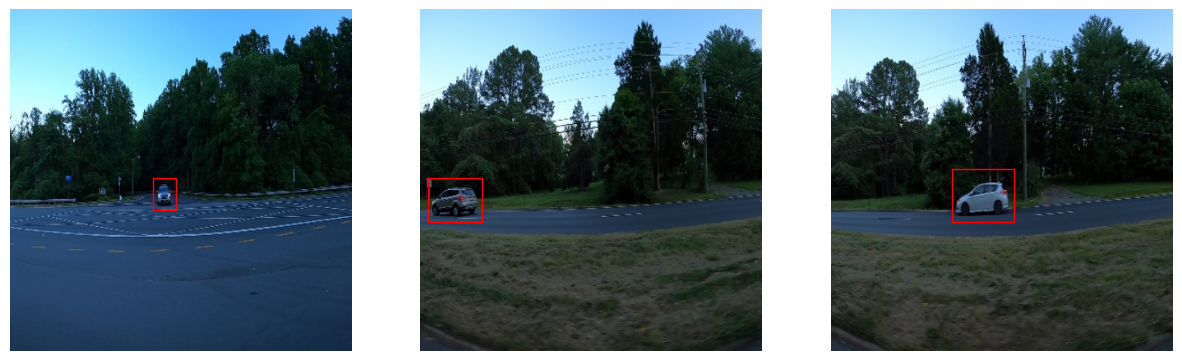

In [11]:


# Constants
TRAIN_IMAGE_DIR = './data/training_images'
TRAIN_ANNOTATION_FILE = './data/train_solution_bounding_boxes.csv'
IMAGE_SIZE = 416  # Typical size for YOLO models

def load_annotations(annotation_file):
    """ Load annotations from a CSV file. """
    df = pd.read_csv(annotation_file)
    annotations = {}
    for _, row in df.iterrows():
        img_id = row['image']
        if img_id not in annotations:
            annotations[img_id] = []
        # Assuming columns are named 'xmin', 'ymin', 'xmax', 'ymax' for the bounding boxes
        annotations[img_id].append([row['xmin'], row['ymin'], row['xmax'], row['ymax']])
    return annotations

def preprocess_image(image_path, image_size):
    """ Load an image and resize to a given size. """
    image = cv2.imread(image_path)
    original_size = image.shape[:2]  # height, width
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (image_size, image_size))
    image = image / 255.0  # Normalize to [0, 1]
    scale = (image_size / original_size[1], image_size / original_size[0])  # width_scale, height_scale
    return image, scale

def visualize_samples(image_dir, annotations, num_samples=3):
    """ Visualize sample images with bounding boxes. """
    plt.figure(figsize=(15, 5))
    sample_images = list(annotations.keys())[:num_samples]
    for i, img_id in enumerate(sample_images):
        ax = plt.subplot(1, num_samples, i + 1)
        img_path = os.path.join(image_dir, img_id)
        image, scale = preprocess_image(img_path, IMAGE_SIZE)
        plt.imshow(image)
        width_scale, height_scale = scale
        for box in annotations[img_id]:
            # Apply scale to bounding box coordinates
            x1, y1, x2, y2 = box
            x1_scaled = x1 * width_scale
            y1_scaled = y1 * height_scale
            x2_scaled = x2 * width_scale
            y2_scaled = y2 * height_scale
            rect = plt.Rectangle((x1_scaled, y1_scaled), x2_scaled - x1_scaled, y2_scaled - y1_scaled, fill=False, color='red')
            ax.add_patch(rect)
        plt.axis('off')
    plt.show()

# Load annotations and visualize sample images
annotations = load_annotations(TRAIN_ANNOTATION_FILE)
visualize_samples(TRAIN_IMAGE_DIR, annotations)

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Constants
IMAGE_SIZE = 416
NUM_CLASSES = 1  # Assuming 'car' is your only class besides background

def create_yolo_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=NUM_CLASSES):
    """Create a simple convolutional model resembling a very simplified YOLO architecture."""
    inputs = Input(input_shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    # Output layer: 5 * num_classes where 5 represents (x, y, w, h, confidence)
    outputs = Dense(num_classes * 5, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

def custom_yolo_loss(y_true, y_pred):
    """Placeholder for the YOLO loss function. Adjust based on your specific needs."""
    # Simplified loss calculation
    # This should be a combination of a coordinate loss (MSE) and an object loss (binary cross-entropy)
    coordinate_loss = tf.reduce_sum(tf.square(y_true[..., :4] - y_pred[..., :4]))
    object_loss = tf.keras.losses.binary_crossentropy(y_true[..., 4:], y_pred[..., 4:])
    return coordinate_loss + object_loss

# Create the model
model = create_yolo_model()

# Compile the model using 'learning_rate' instead of 'lr'
model.compile(optimizer=Adam(learning_rate=0.001), loss=custom_yolo_loss, metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 416, 416, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 416, 416, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 208, 208, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 208, 208, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 104, 104, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 104, 104, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 692224)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    88,604,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,629,029 (338.09 MB)

 Trainable params: 88,629,029 (338.09 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
def create_simplified_yolo_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=NUM_CLASSES):
    """Create a simpler convolutional model for reduced computational demand."""
    inputs = Input(input_shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes * 5, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model


In [18]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import os

# Constants
IMAGE_SIZE = 416
BATCH_SIZE = 32
EPOCHS = 50
TRAIN_IMAGE_DIR = 'data/training_images'
TRAIN_ANNOTATION_FILE = 'data/train_solution_bounding_boxes.csv'

# Assume 'images' and 'labels' are loaded and preprocessed datasets
# For example purposes, they need to be loaded with your actual data loading logic
images, labels = None, None  # Replace with actual data loading code

# Callbacks
checkpoint_path = "training_1/cp-{epoch:04d}.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights only at the end of every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')  # To save weights every 5 epochs, use save_freq=5 * steps_per_epoch if needed

# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

# Load the previously created model
model = create_yolo_model()

# Compile the model if it hasn't been compiled already in the model creation step
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=custom_yolo_loss, metrics=['accuracy'])

# Train the model
history = model.fit(
    images, 
    labels, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    callbacks=[cp_callback, tensorboard_callback]
)

# Save the final model
model.save('final_model.h5')


AttributeError: 'NoneType' object has no attribute 'shape'